In [1]:
import pandas as pd
import spacy
import emoji
import re

# Load the cleaned, randomized reviews CSV
df = pd.read_csv('../data/tinder_reviews_randomized.csv')

In [3]:
# Basic info and shape
print(df.shape)
df.info()
df.describe(include='all')

(50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              50000 non-null  object
 1   userName              50000 non-null  object
 2   userImage             50000 non-null  object
 3   content               49994 non-null  object
 4   score                 50000 non-null  int64 
 5   thumbsUpCount         50000 non-null  int64 
 6   reviewCreatedVersion  42656 non-null  object
 7   at                    50000 non-null  object
 8   replyContent          2142 non-null   object
 9   repliedAt             2142 non-null   object
 10  appVersion            42656 non-null  object
 11  star                  50000 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 4.6+ MB


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,star
count,50000,50000,50000,49994,50000.000000,50000.000000,42656,50000,2142,2142,42656,50000.000000
unique,50000,4954,4979,38638,NaN,NaN,275,49985,90,2102,275,NaN
top,d173eccf-18e8-4ce3-9e5d-88d1d3d74040,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good,NaN,NaN,15.23.0,2022-10-31 23:25:36,Thank you for your comment. We're sorry you di...,2024-01-29 12:25:57,15.23.0,NaN
freq,1,45022,45022,1961,NaN,NaN,2213,2,239,2,2213,NaN
mean,NaN,NaN,NaN,NaN,3.000000,3.004220,NaN,NaN,NaN,NaN,NaN,3.000000
std,NaN,NaN,NaN,NaN,1.414228,50.985821,NaN,NaN,NaN,NaN,NaN,1.414228
min,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2.000000
50%,NaN,NaN,NaN,NaN,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,3.000000
75%,NaN,NaN,NaN,NaN,4.000000,0.000000,NaN,NaN,NaN,NaN,NaN,4.000000


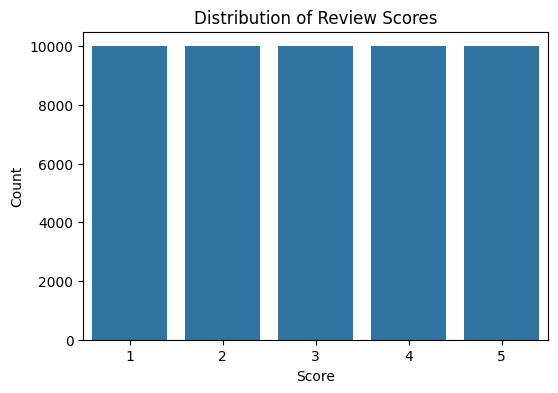

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='score', data=df)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [9]:
import spacy
import re

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r'http\\S+|www\\.\\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.replace('!', ' _EXCLAMATION_ ').replace('?', ' _QUESTION_ ')
    text = re.sub(r'[^a-zA-Z0-9_\\s]', '', text)
    doc = nlp(text)
    negations = {"no", "not", "nor", "never"}
    tokens = [
        token.lemma_ for token in doc
        if (token.is_alpha or token.text in ["_EXCLAMATION_", "_QUESTION_"])
        and (token.text not in nlp.Defaults.stop_words or token.text in negations)
    ]
    return ' '.join(tokens)

# Create the clean_content column
df['clean_content'] = df['content'].astype(str).apply(clean_and_lemmatize)

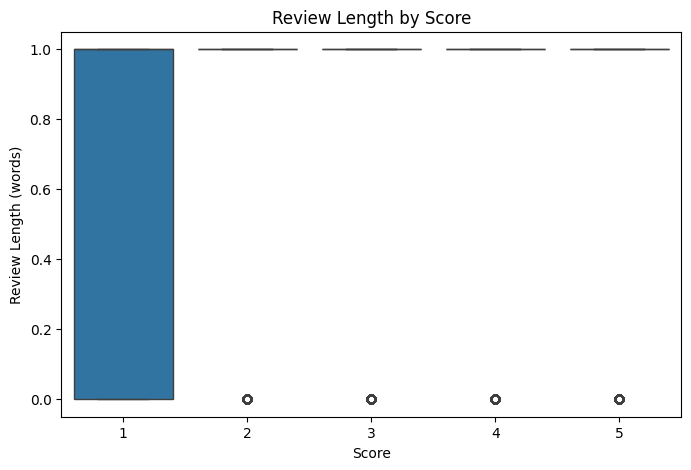

In [10]:
# Add review length column (word count)
df['review_length'] = df['clean_content'].apply(lambda x: len(str(x).split()))

# Boxplot: review length vs. score
plt.figure(figsize=(8,5))
sns.boxplot(x='score', y='review_length', data=df)
plt.title('Review Length by Score')
plt.xlabel('Score')
plt.ylabel('Review Length (words)')
plt.show()

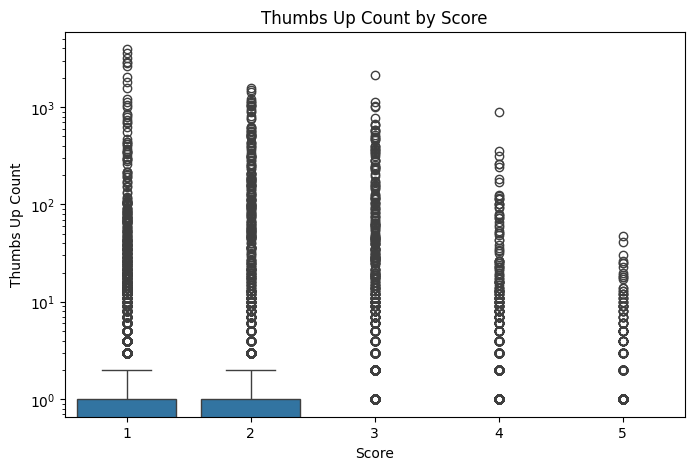

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x='score', y='thumbsUpCount', data=df)
plt.title('Thumbs Up Count by Score')
plt.xlabel('Score')
plt.ylabel('Thumbs Up Count')
plt.yscale('log')  # Use log scale if there are large outliers
plt.show()

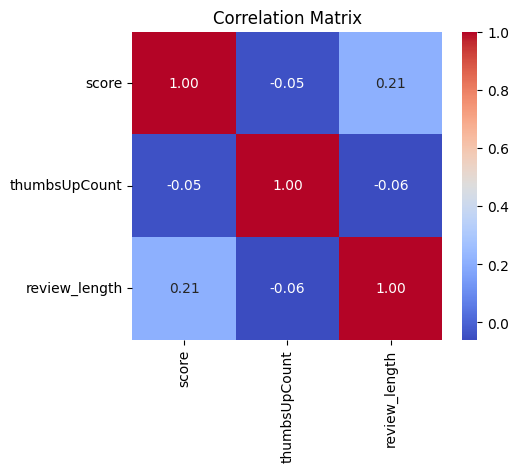

In [12]:
corr_cols = ['score', 'thumbsUpCount', 'review_length']
corr = df[corr_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

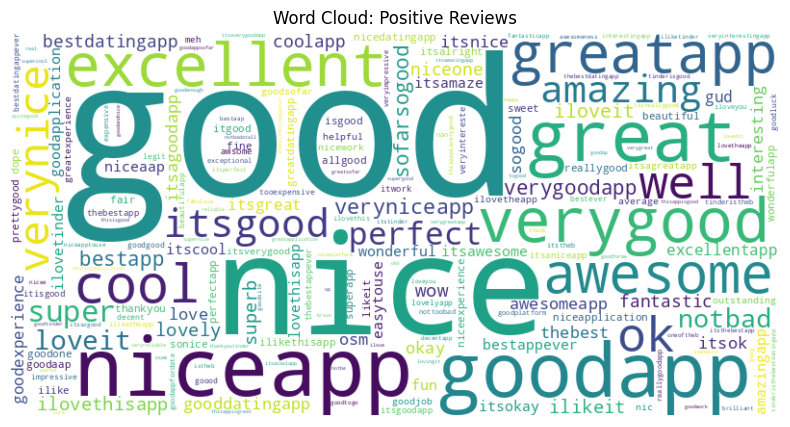

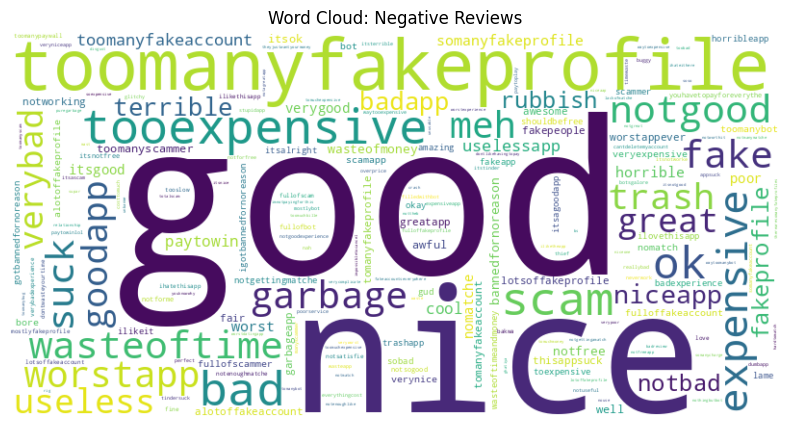

In [14]:
from wordcloud import WordCloud

# Positive reviews (score 4-5)
pos_text = ' '.join(df[df['score'] >= 4]['clean_content'].dropna())
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Positive Reviews')
plt.show()

# Negative reviews (score 1-2)
neg_text = ' '.join(df[df['score'] <= 2]['clean_content'].dropna())
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Negative Reviews')
plt.show()

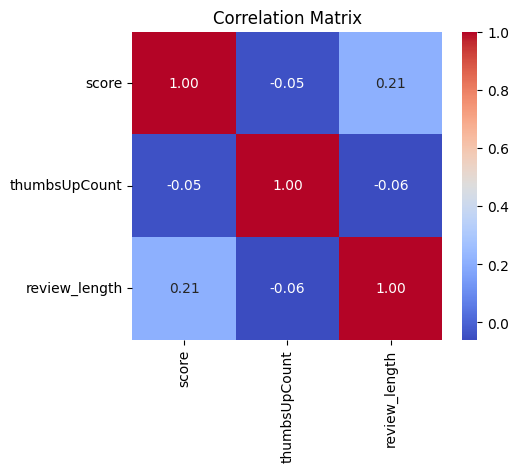

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numerical columns
corr_cols = ['score', 'thumbsUpCount', 'review_length']
corr = df[corr_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

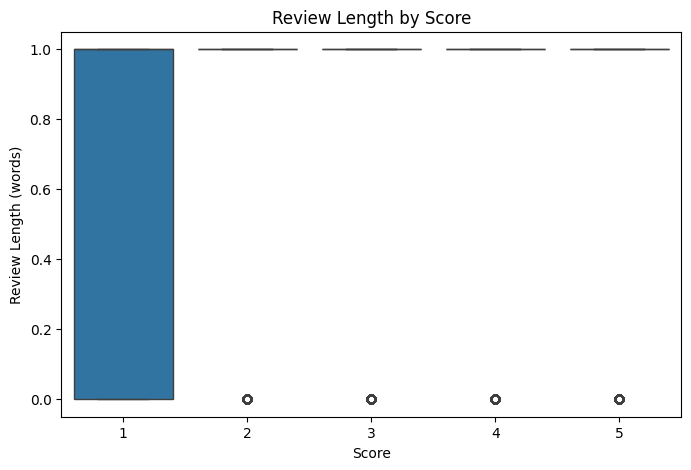

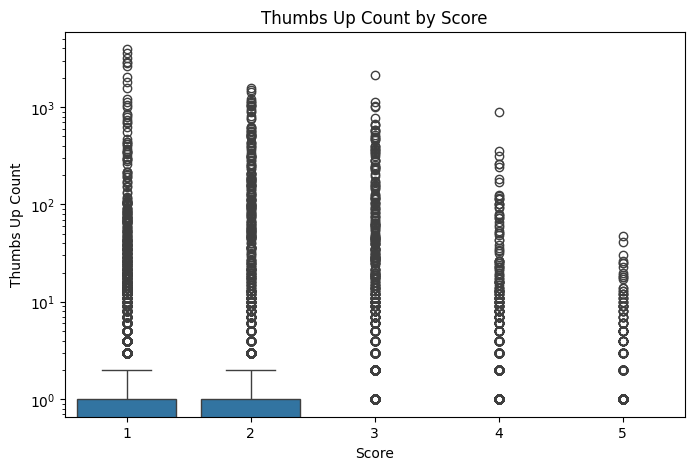

In [20]:
# Review length by score
plt.figure(figsize=(8,5))
sns.boxplot(x='score', y='review_length', data=df)
plt.title('Review Length by Score')
plt.xlabel('Score')
plt.ylabel('Review Length (words)')
plt.show()

# Thumbs up count by score
plt.figure(figsize=(8,5))
sns.boxplot(x='score', y='thumbsUpCount', data=df)
plt.title('Thumbs Up Count by Score')
plt.xlabel('Score')
plt.ylabel('Thumbs Up Count')
plt.yscale('log')  # Use log scale if there are large outliers
plt.show()

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Example: Cramér’s V between appVersion and score
print("Cramér’s V (appVersion vs. score):", cramers_v(df['appVersion'].fillna('unknown'), df['score']))
print("Cramér’s V (reviewCreatedVersion vs. score):", cramers_v(df['reviewCreatedVersion'].fillna('unknown'), df['score']))

Cramér’s V (appVersion vs. score): 0.40502658207897957
Cramér’s V (reviewCreatedVersion vs. score): 0.40502658207897957


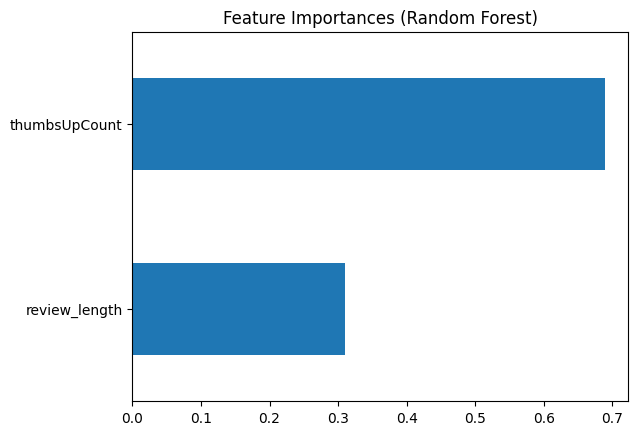

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Example: Predicting positive (score >= 4) vs. not
df['is_positive'] = (df['score'] >= 4).astype(int)
features = ['thumbsUpCount', 'review_length']  # Add more features as needed

X = df[features].fillna(0)
y = df['is_positive']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title('Feature Importances (Random Forest)')
plt.show()

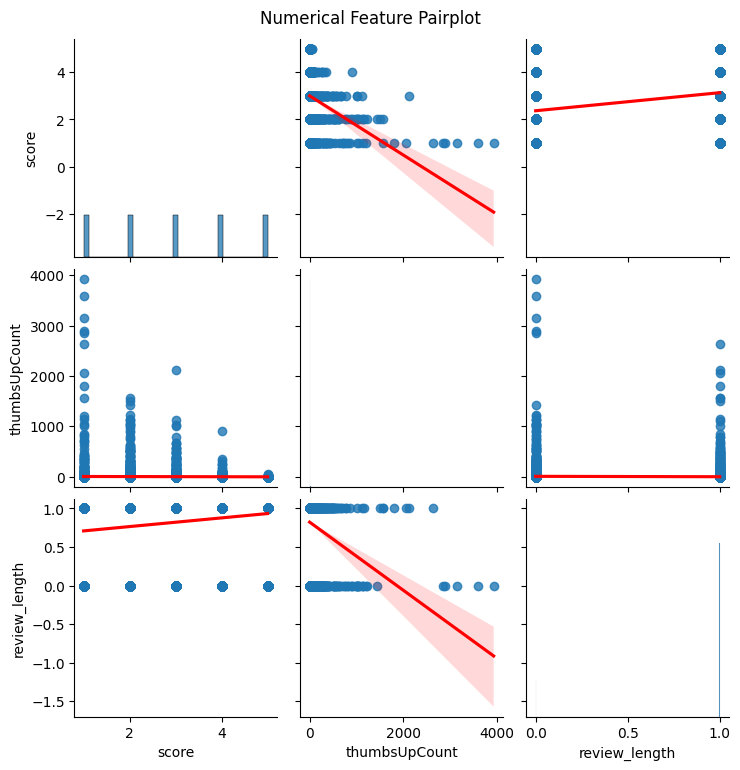

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
num_cols = ['score', 'thumbsUpCount', 'review_length']

sns.pairplot(df[num_cols], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Numerical Feature Pairplot', y=1.02)
plt.show()

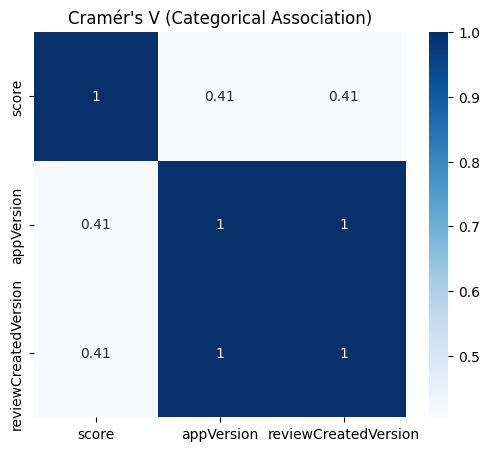

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Choose categorical columns (limit to those with not too many unique values)
cat_cols = ['score', 'appVersion', 'reviewCreatedVersion']  # Add more if desired

# Compute Cramér’s V matrix
cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(df[col1].fillna('unknown'), df[col2].fillna('unknown'))

cramers_matrix = cramers_matrix.astype(float)

plt.figure(figsize=(6,5))
sns.heatmap(cramers_matrix, annot=True, cmap='Blues')
plt.title("Cramér's V (Categorical Association)")
plt.show()

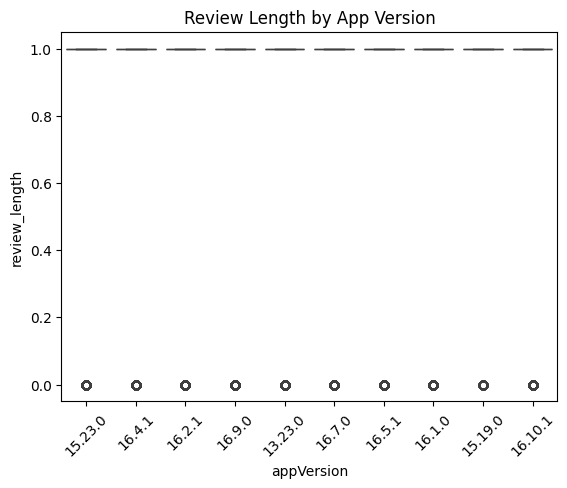

In [25]:
# Example: Boxplot of review_length by appVersion (limit to top 10 versions for clarity)
top_versions = df['appVersion'].value_counts().index[:10]
sns.boxplot(x='appVersion', y='review_length', data=df[df['appVersion'].isin(top_versions)])
plt.title('Review Length by App Version')
plt.xticks(rotation=45)
plt.show()

In [27]:
print(df.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'star', 'clean_content', 'review_length',
       'is_positive'],
      dtype='object')


In [29]:
print(df.dtypes)
print(df.columns.tolist())

reviewId                object
userName                object
userImage               object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
replyContent            object
repliedAt               object
appVersion              object
star                     int64
clean_content           object
review_length            int64
is_positive              int64
dtype: object
['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'star', 'clean_content', 'review_length', 'is_positive']


In [30]:
print(df.columns[df.columns.duplicated()])

Index([], dtype='object')


In [31]:
for col in num_cols + ['score']:
    print(f"{col}: {df[col].shape}, type: {df[col].apply(type).unique()}")

score: (50000,), type: [<class 'int'>]
thumbsUpCount: (50000,), type: [<class 'int'>]
review_length: (50000,), type: [<class 'int'>]
score: (50000,), type: [<class 'int'>]


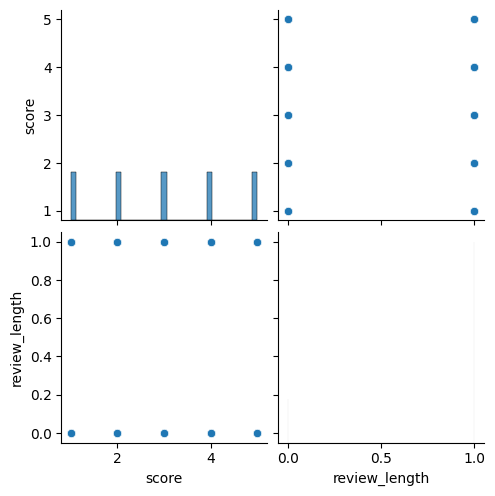

In [32]:
sns.pairplot(df[['score', 'review_length']])
plt.show()

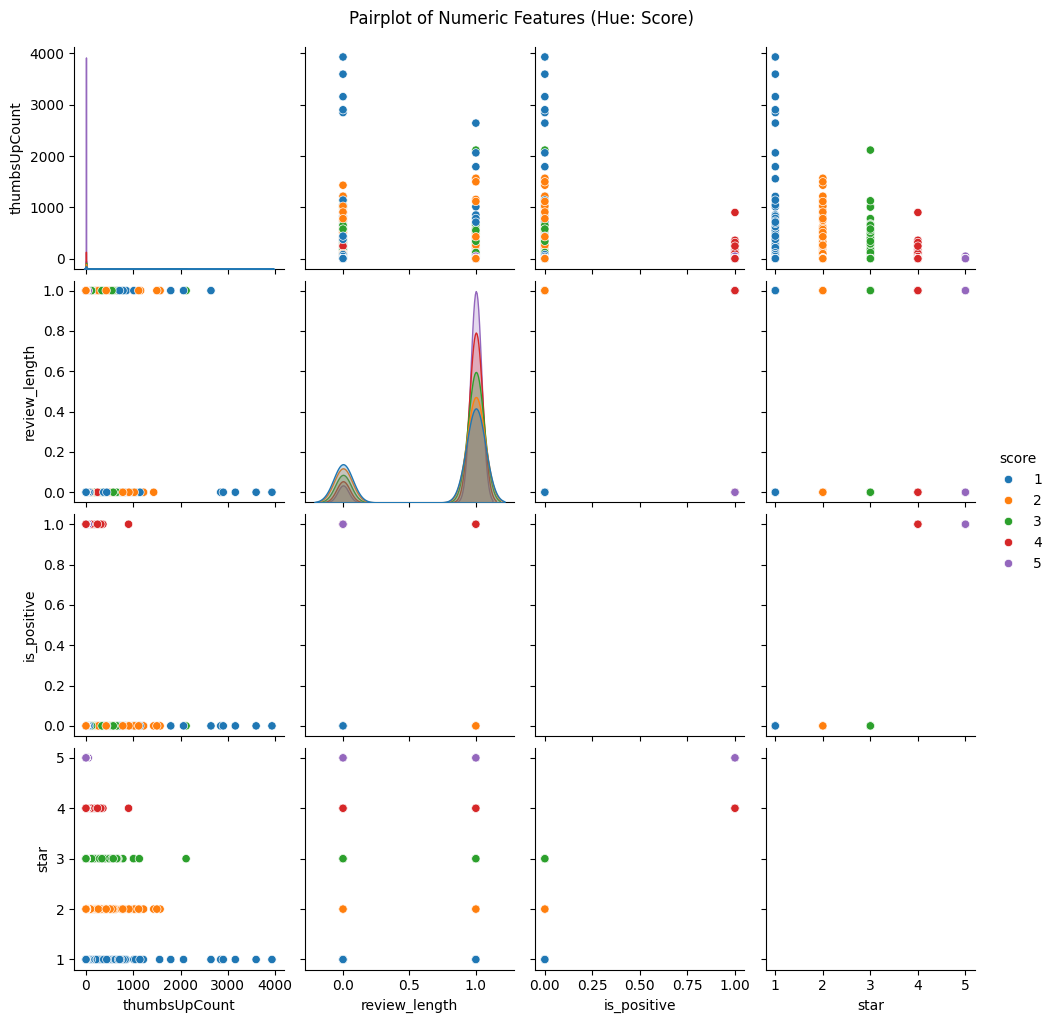

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for the pairplot
numeric_cols = ['score', 'thumbsUpCount', 'review_length', 'is_positive', 'star']

# Drop rows with any NaN in these columns (shouldn't be any, but just in case)
df_numeric = df[numeric_cols].dropna()

# Run the pairplot
sns.pairplot(df_numeric, hue='score', palette='tab10')
plt.suptitle('Pairplot of Numeric Features (Hue: Score)', y=1.02)
plt.show()